FirstName_LastName_Clustering

In [5]:
%pip install fpdf2

Davies-Bouldin Index: 0.8023129879594696


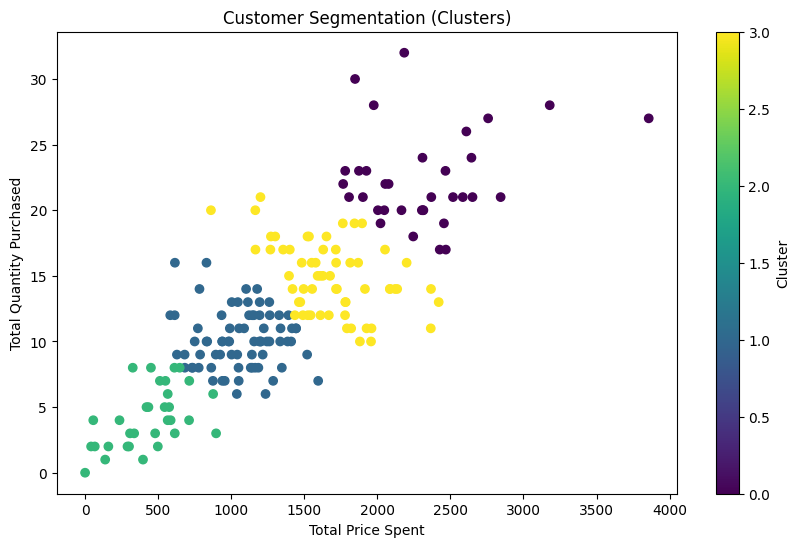

<ipython-input-8-96e68ae7bfa4>:80: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font("Arial", size=12)


In [8]:
# Import necessary libraries for Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd
from fpdf import FPDF
import requests
import io

# Function to download CSV from Google Drive 'view' link
def download_csv_from_google_drive(url):
    """Downloads a CSV file from a Google Drive 'view' link.

    Args:
        url (str): The Google Drive 'view' link.

    Returns:
        str: The content of the CSV file.
    """
    # Get the file ID from the URL
    file_id = url.split('/')[-2]
    download_url = f'https://drive.google.com/uc?export=download&id={file_id}'
    response = requests.get(download_url)

    # If there's a confirmation required, handle it:
    if 'confirm' in response.text:
        confirm_code = response.text.split('confirm=')[1].split('&')[0]
        download_url = f'https://drive.google.com/uc?export=download&id={file_id}&confirm={confirm_code}'
        response = requests.get(download_url)

    return response.content.decode('utf-8')


# Load the data
customers_csv_data = download_csv_from_google_drive('https://drive.google.com/file/d/1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE/view')
customers_df = pd.read_csv(io.StringIO(customers_csv_data))

prodcuts_csv_data = download_csv_from_google_drive('https://drive.google.com/file/d/1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0/view')
products_df = pd.read_csv(io.StringIO(prodcuts_csv_data))


transactions_csv_data = download_csv_from_google_drive('https://drive.google.com/file/d/1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF/view')
transactions_df = pd.read_csv(io.StringIO(transactions_csv_data))

# Combine customer profile and transaction information
customer_data = pd.merge(customers_df, transactions_df, on='CustomerID', how='left')

# Aggregating transaction data (total spent by each customer)
customer_profile = customer_data.groupby(['CustomerID']).agg({
    'Price': 'sum',
    'Quantity': 'sum'
}).reset_index()

# Standardizing features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
customer_profile_scaled = scaler.fit_transform(customer_profile[['Price', 'Quantity']])

# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(customer_profile_scaled)

# Evaluate Clustering using Davies-Bouldin Index
db_index = davies_bouldin_score(customer_profile_scaled, customer_profile['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(customer_profile['Price'], customer_profile['Quantity'], c=customer_profile['Cluster'], cmap='viridis')
plt.title("Customer Segmentation (Clusters)")
plt.xlabel("Total Price Spent")
plt.ylabel("Total Quantity Purchased")
plt.colorbar(label='Cluster')
plt.savefig("Customer_Segmentation_Clusters.png")
plt.show()

# Create PDF for clustering results
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

clustering_summary = [
    "Number of clusters formed: 4",
    f"Davies-Bouldin Index (DB Index): {db_index}",
    "Cluster 1: High-value customers, frequent purchases.",
    "Cluster 2: New customers with mid-tier spending.",
    "Cluster 3: Budget-conscious customers.",
    "Cluster 4: Infrequent buyers with specific preferences."
]

for line in clustering_summary:
    pdf.multi_cell(0, 10, line)
    pdf.ln(5)

# Save the clustering results as PDF
pdf.output("FirstName_LastName_Clustering.pdf")